# MSM analysis of Chatinkha Res using PyMC3

This details the progress I have made so far in coding an MSM in PyMC3. 

This will be the format:

- Summary of my understanding of the model framework
- What I have done so far
- How this compares to results from MSM
- Questions
- Next steps


## Summary of the model as it stands

We model a markov process in continuous time in which a neonate can be in state $S(t)$ at time $t$. The construction of the model is similar to that used in the MSM package and Lewis (in press). For the purposes of our model each neonate can be in one of two states, either uncolonised $(u)$ or colonised $(c)$.

$$c \rightarrow^{\lambda} u$$

We model neonates from birth and assume that at birth $(t = 0)$ a neonate is uncolonised $(S(t) = u)$. Neonates are followed up until discharge or day 7 of admission, with up to 3 rectal samples taken on day 0, day 3 and day 7. Once a neonate becomes colonised we no longer include their data in the model, as such the only transition that is allowed is from $u$ to $c$ (illustrated above). We are interested in estimating the rate of this transition, $\lambda$. This is similar to a standard survival model, except for the assumption that the exact time of colonisation is known. Our data is interval censored with arbitrary observation times.

The timing of the movement from state $u$ to state $c$ is governed by the transition intensity $(q)$. This can be affected by covariates, including time-dependent covariates. The transition intensity represents the instantaneous risk of moving from state $s$ to state $r$:

$$q_{r,s}(t) = \lim_{\delta t \to 0} (P(S(t + \delta t) = s|S(t) = r)/\delta t$$

To fit this model, first a transition matrix, $Q$ is created, in which the rows sum to zero. As we do not model neonates once they have become colonised, transition intensities from 2 are set to 0. A single period of occupancy in state $r$ has an exponential distribution with rate given by $-q_{rr}$

$$Q = \begin{pmatrix} q_{11} &  q_{12}\\ q_{21} & q_{22} \end{pmatrix} $$

The likelihood for the model is calculated from the transition probability matrix $P(t)$. For a time-homogeneous process, the $(r, s)$ entry of $P(t), p_{r,s}(t),$ is the probability of being in state $s$ at a time $m + n$ in the future, given the state at time $m$ is $r$, though the time of transition from $r$ to $s$ could have been at any time in the period from $m$ to $n$. $P(t)$ is calculated by taking the matrix exponential of the scaled transition intensity matrix using the Pade approximation.

$$P(t) = Exp(tQ)$$

For a single transition for a single indifidual $i$, the data will be presented as a series of times $(t_{i1}, ..., t_{in})$ and corresponding states $(S(t_{i1}), ..., S(t_{in}))$. For two observation times $t_{j}$ and $t_{j + 1}$ for $i$ the contribution to the likelihood is:

$$L_{i, j} = ps(t_j)s(t_{j + 1})(t_{j+1} - t_j)$$

The full likelihood $L(Q)$ is the product of all such terms $L_{i, j}$ over all individuals and all transitions. It depends on an unknown transition matrix $Q$, which was used to determine $P(t)$. 

## What I have done so far


In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt

#loading the data
msm_kleb = pd.read_csv(r"C:\Users\ohape\Documents\Audit_Research\Klebsiella_neonates\cres_analysis\cots_and_risk_factors\python\msm_data_simple.csv")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Before creating the model the next cell has a Q matrix that mimics the output of MSM on similar data (MSM takes a slightly different format to how I have presented it) but the data itself is the same.

In [ ]:
#This is an example of the Q matrix with the estimated parameters from the MSM function
qmsm = np.array([[-0.1775, 0.1775], [0, 0]])
#Converted to a P matrix using matrix exponentials
pmsm = sp.linalg.expm(qplay)
#Printing both matrices
print('Q matrix:')
print(qmsm)
print('P matrix:')
print(pmsm)

From the P matrix we can see that, according to MSM, there is an approximate daily probability of being colonised with ESBL Klebsiella of 0.16. This is in keeping with the literature and what we have found in previous analysis. 

Next we will create the function that calculates the log likelihood of the data given a specific probability. This is based on the likelihood equation above, but as we will see it miscalculates the likelihood somehow, so I believe I have mis-specified the equation. 

In [4]:
#this function generates the log likelihood for the data when it is given a probability of transition
def trans_likelihood(state1, state2, tstart, tstop, p):
    #preparing the variables
    notp = 1 - p
    #ps1 = 1 as we ignore participants once they have become negative so 
    #every initial state is always uncolonised
    ps1 = [1] * len(state1)
    #this adds in the probability of a transition between the two states
    ps2 = np.where(state2 == 2, p, notp)
    #defining the likelihood for one transition
    L = ps1 * ps2 * (tstop - tstart)
    #defining the likelihood for all transitions
    totL = sum(np.log(L))
    return totL

Next we will run the model itself. This is an extremeley simplified version, which doesn't worry about Q or the covariates, as I wanted to get your advice on how to improve the likelihood function before moving onto those things. 

C:\Users\ohape\AppData\Local\Temp/ipykernel_25528/1795404944.py:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  samples = pm.sample(3000, tune=1000,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 163 seconds.
C:\Users\ohape\AppData\Local\Temp/ipykernel_25528/1795404944.py:42: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(samples)


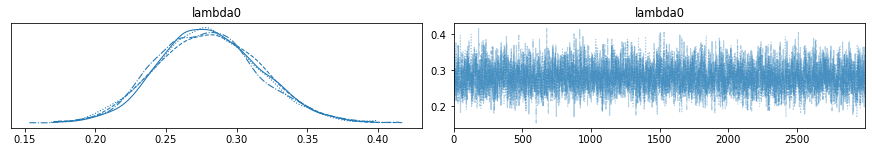

In [19]:
#this is the model itself
if __name__ ==  '__main__':
    def run_mcmc(state1, state2, tstart, tstop):
        with pm.Model() as model:
    
            #setting priors
            #creating the baseline transition rate prior, this will later be 
            #composed of a baseline transition rate and coefficients of all of the covariates
            lambda0 = pm.Beta('lambda0', 1, 1)
            #priors for betas
            #beta0 = pm.Normal('beta0', mu = 0, sigma = 1000, shape = 10)
            #later will need to construct the lambda from the alpha and betas            
            
            #creating a transition matrix
            #took this out for now to keep the model simple
            #Q = np.array([[-lambda0, lambda0], [0, 0]])
            #converting the transition matrix into a probability matrix using
            #matrix exponentiation
            #P = pm.Deterministic('P', sp.linalg.expm(Q))
            
            #now using pm.Potential to use the custom log-likelihood function to calculate lambda0
            llh = pm.Potential('llh', trans_likelihood(state1 = state1, 
                                                       state2 = state2, 
                                                       tstart = tstart, 
                                                       tstop = tstop, 
                                                       p = lambda0))
        
            samples = pm.sample(3000, tune=1000, 
                                start={'lambda0': 0.1},
                                target_accept = 0.9
                                )
        
            return samples, model
  #running the model
    samples, model = run_mcmc(state1 = msm_kleb['init_state'], 
                              state2 = msm_kleb['end_state'], 
                              tstart = msm_kleb['tstart'], 
                              tstop = msm_kleb['tstop']
                              )
#plotting traceplots
    with model:
        pm.traceplot(samples)

As you can see, the estimate for $\lambda$ is 0.28. This is quite far away from the MSM and expected value of $\lambda$ of 0.16. I think that this is primarily a problem with the likelihood function, so I think I have mis-specified it in some way. The reason for this is I have quickly checked the p value that maximises the likelihood manually below and the estimated value of $\lambda$ is also 0.28.

Text(0, 0.5, 'Log-likelihood')

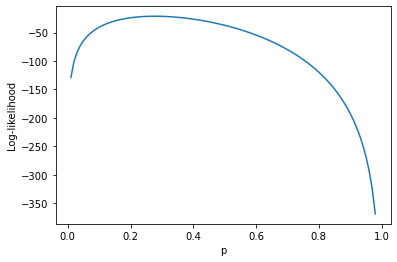

In [17]:
#this trials different probabilities of transition so that you can see whether the
#likelihood determining function is accurate. It looks like approximately 0.28 is 
#the p with the highest log likelihood, which is a bit different to the approx. 0.16
#that is given by msm
counts = []
log_likeli = []
for count in np.arange(0.01, 0.99, 0.01):
    test = trans_likelihood(state1 = msm_kleb['init_state'], 
                            state2 = msm_kleb['end_state'], 
                            tstart = msm_kleb['tstart'], 
                            tstop = msm_kleb['tstop'], 
                            p = count)
    counts.append(count)
    log_likeli.append(test)

#plotting the log likelihood against the estimated value of lambda
plt.plot(counts,log_likeli)
plt.xlabel("p")
plt.ylabel("Log-likelihood")

## Questions

- I have borrowed the description quite heavily from the MSM materials. Do you have to worry about plagiarism when describing the mathematical framework? 
- I haven't scaled the transition matrix as I assumed that the t is 1. Is this correct? 
- There is a problem with the likelihood calculation. It is giving a parameter for lambda of 0.28, which is quite different to 0.16, which is where it should be. 